# **연세-네이버클라우드 데이터사이언스 교육과정: 텍스트마이닝**

## 토픽 모델링(Topic Modeling)

박기영 (연세대 경제학부)

04NLP_TopicModeling.ipynb의 목차

1. 토픽 모델링 개요
2. 잠재 디리클레 할당(LDA: Latent Dirichlet Allocation)
3. 예: sklearn 뉴스그룹 데이터를 이용한 LDA 분석



In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas_datareader as pdr
from datetime import date

import seaborn as sns

%config InlineBackend.figure_format = 'retina'   # for retina display in Mac
np.set_printoptions(precision=3, suppress=True)  # for pretty display of numpy arrays
pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 10

In [2]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=16)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
mpl.rc('font', size=16)
plt.rc('legend', fontsize=16) 

# for Korean fonts 
plt.rcParams['axes.unicode_minus'] = False

# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(14,8)})

In [3]:
# 각 셀마다 소요 시간 측정
!pip install ipython-autotime
%load_ext autotime

time: 198 µs (started: 2021-02-10 06:09:45 +00:00)


## 토픽 모델링(Topic Modeling)

- 토픽 모델링은 문서들의 집합에서 주제('토픽')들을 찾는 작업
- 고객 피드백, 검색엔진 등과 같이 문서의 주제를 알아내는 것이 중요한 부분에서 활용될 수 있음. 
- 예: 고객 피드백 10,000개 중에서 공통적으로 많이 나타나는 주제 5개를 찾을 수 있음. (구체적으로 어떤 주제인지는 해당 주제에서 많이 출현하는 단어들을 보고 개발자가 파악해야 함)
- **비지도학습**이며 관련 개념은 이미지의 비지도학습에도 사용됨.
  - 20쪽 그림 참고: https://www.dropbox.com/s/48tcomnvjduyf4v/presentation_ERTI.pdf?dl=0
- LSA (Latent Semantic Analysis), PLSA (Probabilistic Latent Semantic Analysis) 등도 사용되지만 시간 관계상 토픽 모델링의 대표적 알고리듬인 잠재 디리클레 할당(LDA: Latent Dirichlet Allocation)에 대해서만 살펴 봄. 
- 아래에서는 수학적 접근은 지양하고 예와 직관을 통해 설명함. 

## 잠재 디리클레 할당(Latent Dirichlet Allocation, LDA)

- 기본적 가정은 

> "개별 문서(document)는 주제들(topics)의 분포(distribution)로 묘사될 수 있으며, 개별 주제는 다시 단어들(words)의 분포로 묘사될 수 있다."

- 역으로 단어들의 분포를 통해 문서들의 '숨어있는(latent, hidden)' 주제를 파악하는 것이 LDA의 기본적인 접근법임. 

- 일종의 'reverse engineering'임.

- 디리클레(Dirichlet) 분포:
\begin{equation}
f(x_{1},...,x_{k};\alpha_{1},...,\alpha_{k}) = \frac{1}{B(\alpha)}\Pi_{i=1}^{k}x_{i}^{\alpha_{i}-1}
\end{equation}
where
\begin{equation}
B(\alpha) = \frac{ \Pi_{i=1}^{k} \Gamma(\alpha_{i})}{\Gamma (\Sigma^{k}_{i=1} \alpha_{i})}
\end{equation}
  - 디리클레 분포에서 $\Sigma_{i=1}^{k} x_{i}=1, \forall x_{i}\geq 0$를 만족하는 $k$개의 연속형 확률변수($x_{1},...,x_{k}$)를 샘플링할 수 있음.  
  - 중요한 점은 $\Sigma_{i=1}^{k} x_{i}=1, \forall x_{i}\geq 0$임 $\rightarrow$ 확률분포로 사용할 수 있음. 
- LDA에서 $N$개의 문서에서 $k$개의 주제를 찾으라고 설정할 수 있는데 이때 디리클레 분포는 $k$개 주제의 확률분포를 추출하는데 사용됨.
- LDA에 대한 수학적 접근은 다음을 참고할 것:
  - Blei, Ng, and Jordan (2013): https://ai.stanford.edu/~ang/papers/jair03-lda.pdf

- 다음 사이트는 문서들을 입력할 경우 웹상에서 DTM을 만들고 LDA를 수행하는 사이트임. 
  - https://lettier.com/projects/lda-topic-modeling/
- 위 사이트의 $\alpha$, $\beta$ 파라미터에 대한 설명을 다음을 참고할 것:
  - https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158
  - https://stats.stackexchange.com/questions/244917/what-exactly-is-the-alpha-in-the-dirichlet-distribution
- 위 사이트의 예를 통해서 LDA를 이해해 보자. 
  - 아래 그림은 4개의 문서(Document 0, 1, 2, 3)에서 2개의 토픽을 찾는 경우를 보여줌. 
  - 한 눈에 봐도 Document 2와 3의 지배적인 주제는 '모자'임을 알 수 있고, Document 1에서는 '고양이' 주제가 주로 논의되고, 그 다음으로 '모자'가 논의되고 있음.

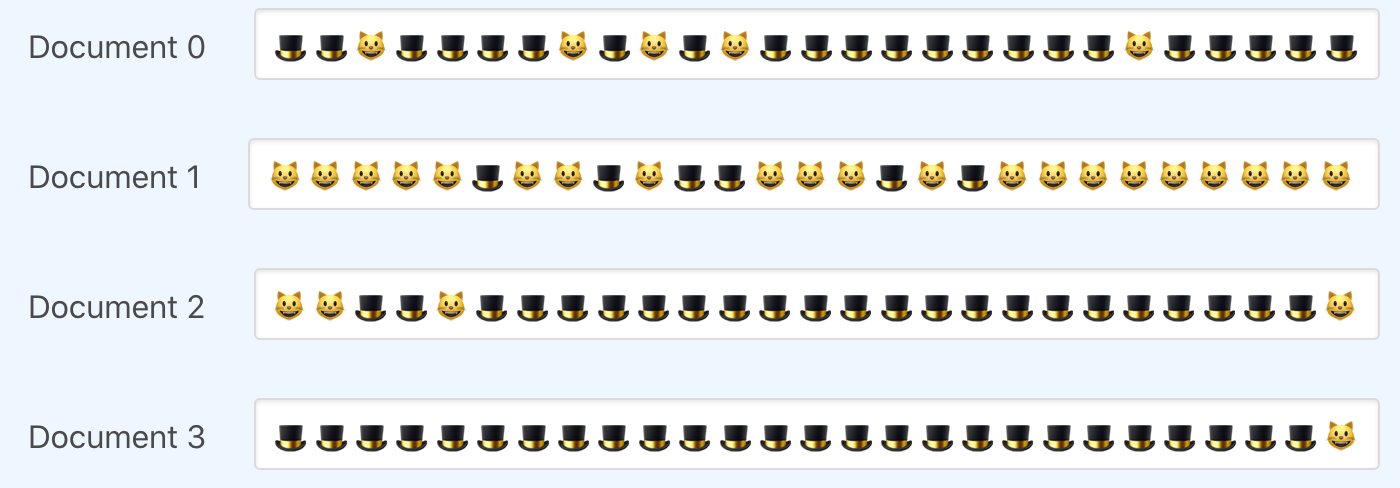

- 위에 나타난 패턴을 표로 정리하면 아래와 같은데 LDA의 결과물도 유사함.

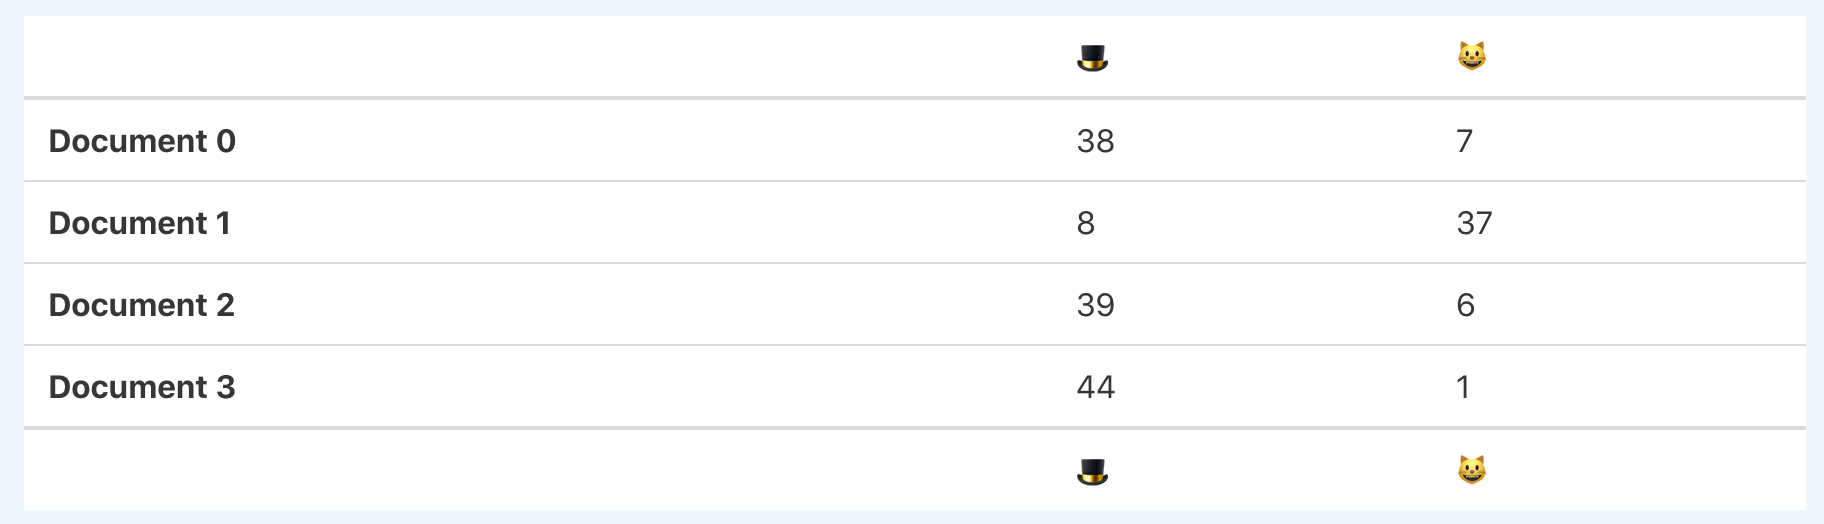

- 4개의 문서에서 2개의 주제로 토픽모델링을 한다면 결과물은 다음과 같음 (수치는 예시임):
  - 문서 0: 토픽 A 확률 85%, 토픽 B 확률 15%
  - 문서 1: 토픽 A 확률 17%, 토픽 B 확률 83%
  - 문서 2: 토픽 A 확률 90%, 토픽 B 확률 10%
  - 문서 3: 토픽 A 확률 99%, 토픽 B 확률 1%

## 예: sklearn 뉴스그룹 데이터를 이용한 LDA 분석

- 아래 링크에 LDA 분석 사례가 잘 정리되어 있음:
  - https://stackabuse.com/python-for-nlp-working-with-the-gensim-library-part-2/
  - https://wikidocs.net/30708
  - https://towardsdatascience.com/nlp-extracting-the-main-topics-from-your-dataset-using-lda-in-minutes-21486f5aa925

### 1. 데이터 불러오기

In [4]:
# sklearn에서 20개 주제로 분류되어 있는 데이터를 불러 옴
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', shuffle = True) # 모두 불러올 때는 subset='all'
newsgroups_test = fetch_20newsgroups(subset='test', shuffle = True)

time: 734 ms (started: 2021-02-10 06:09:45 +00:00)


In [5]:
# 내용 확인
print(newsgroups_train.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])
time: 1.68 ms (started: 2021-02-10 06:09:46 +00:00)


In [6]:
# 크기 확인
print(newsgroups_train.filenames.shape, newsgroups_train.target.shape)

(11314,) (11314,)
time: 1.32 ms (started: 2021-02-10 06:09:46 +00:00)


In [7]:
# 20개 주제 확인
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

time: 3.49 ms (started: 2021-02-10 06:09:46 +00:00)


In [8]:
# 뉴스들 샘플 확인

print(newsgroups_train.data[10])
print('\n')
print("newsgroup =",newsgroups_train.target[10])

From: irwin@cmptrc.lonestar.org (Irwin Arnstein)
Subject: Re: Recommendation on Duc
Summary: What's it worth?
Distribution: usa
Expires: Sat, 1 May 1993 05:00:00 GMT
Organization: CompuTrac Inc., Richardson TX
Keywords: Ducati, GTS, How much? 
Lines: 13

I have a line on a Ducati 900GTS 1978 model with 17k on the clock.  Runs
very well, paint is the bronze/brown/orange faded out, leaks a bit of oil
and pops out of 1st with hard accel.  The shop will fix trans and oil 
leak.  They sold the bike to the 1 and only owner.  They want $3495, and
I am thinking more like $3K.  Any opinions out there?  Please email me.
Thanks.  It would be a nice stable mate to the Beemer.  Then I'll get
a jap bike and call myself Axis Motors!

-- 
-----------------------------------------------------------------------
"Tuba" (Irwin)      "I honk therefore I am"     CompuTrac-Richardson,Tx
irwin@cmptrc.lonestar.org    DoD #0826          (R75/6)
-------------------------------------------------------------------

In [9]:
# 특정 카테고리만 분석할 경우
categories = [
  'alt.atheism',
  'rec.autos',
  'rec.sport.baseball',
  'sci.electronics',
  'sci.med',
]

newsgroups_train = fetch_20newsgroups(subset='train', categories = categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories = categories)

time: 632 ms (started: 2021-02-10 06:09:46 +00:00)


In [10]:
# 크기 확인
print(newsgroups_train.filenames.shape, newsgroups_train.target.shape)

(2856,) (2856,)
time: 1.34 ms (started: 2021-02-10 06:09:47 +00:00)


### 2. 전처리(Preprocessing)

- 토큰화
- 소문자화
- 불용어 제거
- lemmatization, stemming

In [11]:
# 토픽 모델링에 강점을 보이는 gensim 사용
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

time: 428 ms (started: 2021-02-10 06:09:47 +00:00)


In [12]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

time: 76.6 ms (started: 2021-02-10 06:09:47 +00:00)


In [13]:
# lemmatization 중 동사 현재화 예
print(WordNetLemmatizer().lemmatize('had', pos = 'v'))

have
time: 1.68 s (started: 2021-02-10 06:09:47 +00:00)


In [14]:
# # stemming 예
stemmer = SnowballStemmer("english")
original_words = ['democracy','precious','ended','sought','tremendous']
singles = [stemmer.stem(plural) for plural in original_words]

pd.DataFrame(data={'original word':original_words, 'stemmed':singles })

,original word,stemmed
0,democracy,democraci
1,precious,precious
2,ended,end
3,sought,sought
4,tremendous,tremend


time: 19.3 ms (started: 2021-02-10 06:09:49 +00:00)


In [15]:
# 텍스트 전처리를 위한 함수 정의
# https://towardsdatascience.com/nlp-extracting-the-main-topics-from-your-dataset-using-lda-in-minutes-21486f5aa925

# lemmatize and then stem
def lemmatize_stem(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# 토근화 -> 불용어, 짧은 단어 제거 -> lemmatize_stem() 적용
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stem(token))
            
    return result

time: 6.41 ms (started: 2021-02-10 06:09:49 +00:00)


In [16]:
# 위 함수들이 어떻게 적용되는지 확인

# Biden 대통령 취임사 첫 문장
doc_sample = "This is America's day. This is democracy's day. A day of history and hope, of renewal and resolve."

print("Original document: ")
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print("\n\nTokenized and lemmatized document: ")
print(preprocess(doc_sample))

Original document: 
['This', 'is', "America's", 'day.', 'This', 'is', "democracy's", 'day.', 'A', 'day', 'of', 'history', 'and', 'hope,', 'of', 'renewal', 'and', 'resolve.']


Tokenized and lemmatized document: 
['america', 'democraci', 'histori', 'hope', 'renew', 'resolv']
time: 5.7 ms (started: 2021-02-10 06:09:49 +00:00)


In [17]:
# 전처리
processed_docs = []

for doc in newsgroups_train.data:
    processed_docs.append(preprocess(doc))

time: 7.05 s (started: 2021-02-10 06:09:49 +00:00)


In [18]:
print(processed_docs[10])

['stevewal', 'steve', 'wall', 'subject', 'warn', 'read', 'organ', 'anhedon', 'anonym', 'line', 'nntp', 'post', 'host', 'hipmac', 'pica', 'armi', 'articl', 'convex', 'tobia', 'convex', 'allen', 'tobia', 'write', 'societi', 'know', 'come', 'apart', 'seam', 'basic', 'reason', 'human', 'life', 'devalu', 'point', 'kill', 'deal', 'hundr', 'murder', 'act', 'abort', 'children', 'demand', 'kill', 'sick', 'surpris', 'kid', 'drop', 'rock', 'kill', 'peopl', 'care', 'messag', 'hear', 'life', 'cheap', 'think', 'get', 'littl', 'overheat', 'highway', 'robber', 'life', 'middl', 'age', 'human', 'natur', 'look', 'histori', 'rise', 'color', 'glass', 'random', 'act', 'violenc', 'ceaseless', 'heritag', 'overal', 'life', 'better', 'random', 'individu', 'act', 'violenc', 'histor', 'signific', 'record', 'keep', 'past', 'good', 'retain', 'steve', 'wall']
time: 1.48 ms (started: 2021-02-10 06:09:56 +00:00)


### 3. BOW 만들기

- processed_docs와 gensim.corpora.Dictionary()를 이용해서 단어와 출현 빈도를 표시하는 BOW 만들기

In [19]:
# BOW를 생성하고 dictionary 이름으로 저장
dictionary = gensim.corpora.Dictionary(processed_docs)

time: 343 ms (started: 2021-02-10 06:09:56 +00:00)


In [20]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 ask
1 ball
2 basebal
3 believ
4 blow
5 card
6 cardin
7 clutch
8 coach
9 comment
10 complet
time: 11.7 ms (started: 2021-02-10 06:09:56 +00:00)


In [21]:
# 너무 적게 나오거나 흔하게 나오는 단어들 제거
# no_below=15: 15회 이하 출현 단어
# no_above=0.1: 문서에서 10% 이상 나오는 단어

dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)

time: 41.1 ms (started: 2021-02-10 06:09:56 +00:00)


In [22]:
# 문서마다 BOW (어떤 단어들이 몇 번이나 출현했는지 기록) 만들고 bow_corpus로 저장

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

time: 187 ms (started: 2021-02-10 06:09:56 +00:00)


In [23]:
# 문서 하나를 정해서 해당 문서의 BOW 확인

document_num = 5
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
  a = bow_doc_x[i][0]
  b = dictionary[bow_doc_x[i][0]]
  c = bow_doc_x[i][1]
  print(f'Word number {a} (\"{b}\") appears {c} time(s).')

Word number 23 ("keyword") appears 1 time(s).
Word number 28 ("lower") appears 1 time(s).
Word number 92 ("chang") appears 1 time(s).
Word number 147 ("magnus") appears 2 time(s).
Word number 158 ("ohio") appears 3 time(s).
Word number 161 ("plug") appears 1 time(s).
Word number 178 ("usual") appears 2 time(s).
Word number 202 ("car") appears 1 time(s).
Word number 203 ("colorado") appears 2 time(s).
Word number 204 ("dirti") appears 1 time(s).
Word number 205 ("drain") appears 1 time(s).
Word number 206 ("draw") appears 2 time(s).
Word number 207 ("dump") appears 1 time(s).
Word number 208 ("happen") appears 1 time(s).
Word number 209 ("imagin") appears 1 time(s).
Word number 210 ("key") appears 1 time(s).
Word number 211 ("method") appears 1 time(s).
Word number 212 ("open") appears 2 time(s).
Word number 213 ("place") appears 1 time(s).
Word number 214 ("radiat") appears 1 time(s).
Word number 215 ("real") appears 1 time(s).
Word number 216 ("risk") appears 1 time(s).
Word number 21

### 4. BOW를 이용해서 LDA 분석

- num_topics = 추출할 주제의 수
- id2word = 정수로 표시된 단어 id 에서 스트링으로 표시되는 단어간 맵핑. 이를 통해 결과물을 스트링 단어로 볼 수 있음. 
- workers = 병행처리 수. 디폴트는 이용가능한 모든 코어를 이용. 
- alpha: 문서-토픽의 sparsity에 대한 하이퍼 파라미터. 디폴트는 1/num_topics.
  - alpha가 높을수록 각 문서들이 더 많은 주제들을 포함함 (문사들의 유사도가 높아짐)
- eta: 토픽-단어의 sparsity에 대한 하이퍼 파라미터. 디폴트는 1/num_topics.
  - eta가 높을수록 각 주제들이 다수의 단어들을 공통적으로 사용함 (주제들의 유사도가 높아짐)

In [24]:
# gensim.models.LdaMulticore 를 이용해서 훈련시키고 결과를 LDAmodel에 저장
# https://radimrehurek.com/gensim/models/ldamulticore.html
# passes = 알고리즘의 동작 횟수. 모형이 수렴되도록 적절하게 조정. 

# 앞에서 5 그룹의 뉴스를 지정했음. 여기에서는 모형이 잘 돌아가는지 보여주는 예시를 위해 주제도 5개로 설정
num_topics = 5

LDAmodel =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = num_topics, 
                                   id2word = dictionary,                                    
                                   passes = 15,
                                   workers = 2)
                                   
# for single-core implementation
'''
LDAmodel = gensim.models.ldamodel.LdaModel(bow_corpus, 
                                           num_topics = num_topics, 
                                           id2word=dictionary, 
                                           passes=15) '''

'\nLDAmodel = gensim.models.ldamodel.LdaModel(bow_corpus, \n                                           num_topics = num_topics, \n                                           id2word=dictionary, \n                                           passes=15) '

time: 43.9 s (started: 2021-02-10 06:09:57 +00:00)


- 아래 결과에서 각 단어 앞에 붙은 수치는 단어의 해당 토픽에 대한 기여도임
- num_words: 보여줄 단어의 개수  

In [25]:
topics = LDAmodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.006*"diseas" + 0.005*"doctor" + 0.005*"patient" + 0.005*"studi" + 0.005*"netcom"')
(1, '0.013*"game" + 0.010*"team" + 0.008*"keith" + 0.008*"player" + 0.007*"basebal"')
(2, '0.009*"drive" + 0.009*"car" + 0.008*"engin" + 0.006*"price" + 0.006*"speed"')
(3, '0.009*"pitt" + 0.008*"bank" + 0.007*"gordon" + 0.007*"power" + 0.007*"water"')
(4, '0.009*"atheist" + 0.008*"islam" + 0.008*"exist" + 0.007*"wire" + 0.007*"food"')
time: 4.14 ms (started: 2021-02-10 06:10:40 +00:00)


In [26]:
# 결과 전체를 보고 싶은 경우
LDAmodel.print_topics()

[(0,
  '0.006*"diseas" + 0.005*"doctor" + 0.005*"patient" + 0.005*"studi" + 0.005*"netcom" + 0.004*"evid" + 0.004*"treatment" + 0.004*"scientif" + 0.004*"candida" + 0.004*"medic"'),
 (1,
  '0.013*"game" + 0.010*"team" + 0.008*"keith" + 0.008*"player" + 0.007*"basebal" + 0.006*"pitch" + 0.006*"caltech" + 0.006*"run" + 0.005*"season" + 0.005*"play"'),
 (2,
  '0.009*"drive" + 0.009*"car" + 0.008*"engin" + 0.006*"price" + 0.006*"speed" + 0.005*"list" + 0.005*"uiuc" + 0.004*"auto" + 0.004*"chang" + 0.004*"dealer"'),
 (3,
  '0.009*"pitt" + 0.008*"bank" + 0.007*"gordon" + 0.007*"power" + 0.007*"water" + 0.006*"circuit" + 0.006*"current" + 0.005*"phone" + 0.004*"inform" + 0.004*"chip"'),
 (4,
  '0.009*"atheist" + 0.008*"islam" + 0.008*"exist" + 0.007*"wire" + 0.007*"food" + 0.007*"atheism" + 0.006*"religion" + 0.006*"christian" + 0.005*"argument" + 0.005*"caus"')]

time: 13.6 ms (started: 2021-02-10 06:10:40 +00:00)


### 6. 새로운 문서를 이용한 테스팅

In [27]:
# 새로운 문서를 newsgroups_test에서 가지고 옴. 
num = 19
unseen_document = newsgroups_test.data[num]
print(unseen_document)

From: franjion@spot.Colorado.EDU (John Franjione)
Subject: Re: Why is Barry Bonds not batting 4th?
Nntp-Posting-Host: spot.colorado.edu
Organization: University of Colorado, Boulder
Lines: 29

st1ge@Elroy.UH.EDU (Edward Hui) writes:

>In article <1993Apr21.032427.22464@leland.Stanford.EDU>, punjabi@leland.Stanford.EDU (sanjeev punjabi) writes:
>>
>>As the heading indicates, it is impossible for me to fathom why Barry is not
>>batting 4th for the Giants behind Will Clark.  Barry is such an awesome and
>>consistent hitter -- definitely the best in the National League.  IMHO, to 
>>have Williams, a streaky hitter (and not really a clutch hitter) batting
>>4th ahead of Bonds is simply an injustice to the Giants and fans of the
>>Giants.

>2 simple reasons:

>(2)   Having Bonds batting behind Williams means that Matt will get
>      more good pitches to hit.  This is important since he struggles
>      so much with breaking balls.  Opposing pitchers don't want to
>      walk Williams to get

In [28]:
# 전처리
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

# 결과
for index, score in sorted(LDAmodel[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, LDAmodel.print_topic(index, 5)))

Score: 0.8974860310554504	 Topic: 0.013*"game" + 0.010*"team" + 0.008*"keith" + 0.008*"player" + 0.007*"basebal"
Score: 0.09482043236494064	 Topic: 0.006*"diseas" + 0.005*"doctor" + 0.005*"patient" + 0.005*"studi" + 0.005*"netcom"
time: 10.8 ms (started: 2021-02-10 06:10:40 +00:00)


In [29]:
# 또는 train set 문서들의 주제를 확인할 수 있음. 여기서는 앞의 5개만 보여줌. 
for i, topic_list in enumerate(LDAmodel[bow_corpus]):
    if i==5:
        break
    print(i,'번째 문서의 topic 비율:',topic_list)

0 번째 문서의 topic 비율: [(1, 0.98853314)]
1 번째 문서의 topic 비율: [(1, 0.98402226)]
2 번째 문서의 topic 비율: [(1, 0.23260714), (4, 0.7480336)]
3 번째 문서의 topic 비율: [(0, 0.5173717), (2, 0.3411442), (4, 0.13752891)]
4 번째 문서의 topic 비율: [(0, 0.12343899), (2, 0.63452464), (4, 0.23149864)]
time: 11.5 ms (started: 2021-02-10 06:10:41 +00:00)


### 7. 시각화

In [30]:
# pyLDAvis 최신 버전은 Google Colab에서 잘 작동하지 않는 경우가 있음

#!pip install pyLDAvis!
!pip install pyLDAvis==2.1.2

time: 2.64 s (started: 2021-02-10 06:10:41 +00:00)


In [31]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(LDAmodel, bow_corpus, dictionary)
pyLDAvis.display(vis)

/usr/local/lib/python3.6/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


time: 3.53 s (started: 2021-02-10 06:10:43 +00:00)


- 좌측의 원들은 각각 토픽을 표시함.
- 각 원과의 거리는 각 토픽들이 서로 얼마나 다른지를 보여줌. 만약 겹쳐진 원들이 있다면 유사한 토픽이라는 의미임. 
- 각 원들을 클릭하면 우측에 해당 토픽에 대한 정보가 나옴. 
- 주의: 주제가 0부터 시작되지 않고 1부터 시작됨. 